<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/AE/AE_AnormalyDetection_MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder


## Import and Config

In [1]:
!pip install -q --upgrade albumentations==0.5.1

In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 28, 28

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

## Define Model

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, dim=32, in_channel=1):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.module_encoder = nn.Sequential(
            Flatten(),
            nn.Linear(IN_HEIGHT * IN_WIDTH * in_channel, dim * 8),
            nn.ReLU(),
            nn.Linear(dim * 8, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim),
            nn.ReLU(),
        )
        
        # Decoder
        self.module_decoder = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim * 8),
            nn.ReLU(),
            nn.Linear(dim * 8, IN_WIDTH * IN_HEIGHT * in_channel),
            nn.Tanh(),
            Reshape(in_channel, IN_HEIGHT, IN_WIDTH)
        )
        
    def forward(self, x):
        x = self.module_encoder(x)
        return self.module_decoder(x)
    
    def forward_encoder(self, x):
        return self.module_encoder(x)

# Dataset

In [5]:
train_ds = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data.numpy()[..., None].astype(np.float32)
train_ys = np.array(train_ds.targets)

target_label = 0
train_Xs = train_Xs[train_ys == target_label]
train_ys = train_ys[train_ys == target_label]

class MnistDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [6]:
transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [7]:
def show_sample(Xs, show_num=8, name="input"):
    Xs = Xs.detach().cpu().numpy()[:, 0]
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.title(name)
        plt.axis('off')
        
    plt.show()

In [8]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_Xs)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_Xs, train_ys, train_ys)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_Xs, train_ys)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    EPOCH = 50
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = MnistDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = MnistDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        model = AutoEncoder()
        model = model.to(device)
        
        criterion = nn.MSELoss()
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
  
        #---
        # epoch
        #---
        for epoch in range(EPOCH):
            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, xs)
                loss = loss# / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += 0#(predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, xs)
                        
                    val_loss += loss.item()# / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += 0#(predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} [val]loss:{val_loss:.4f} [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

            if (epoch + 1) % 10 == 0:
                show_sample(xs, name="input")
                show_sample(outputs, name="output")

        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()

        
    return train_models, train_model_paths


StratifiedKFold fold:1/2
train_N=2961, val_N=2962
fold:1 epoch:1/50 [tra]loss:4.9345 [val]loss:3.8427 [time]total:1.00sec tra:0.53sec val:0.47sec
fold:1 epoch:2/50 [tra]loss:2.7271 [val]loss:2.2035 [time]total:0.99sec tra:0.50sec val:0.49sec
fold:1 epoch:3/50 [tra]loss:2.1384 [val]loss:2.0252 [time]total:0.94sec tra:0.48sec val:0.46sec
fold:1 epoch:4/50 [tra]loss:2.0161 [val]loss:1.9217 [time]total:0.99sec tra:0.49sec val:0.50sec
fold:1 epoch:5/50 [tra]loss:1.9553 [val]loss:1.8790 [time]total:0.95sec tra:0.49sec val:0.46sec
fold:1 epoch:6/50 [tra]loss:1.9100 [val]loss:1.8570 [time]total:0.99sec tra:0.48sec val:0.51sec
fold:1 epoch:7/50 [tra]loss:1.8696 [val]loss:1.8193 [time]total:1.01sec tra:0.51sec val:0.50sec
fold:1 epoch:8/50 [tra]loss:1.8389 [val]loss:1.7628 [time]total:0.99sec tra:0.50sec val:0.49sec
fold:1 epoch:9/50 [tra]loss:1.8012 [val]loss:1.6951 [time]total:1.03sec tra:0.53sec val:0.50sec
fold:1 epoch:10/50 [tra]loss:1.7337 [val]loss:1.6121 [time]total:1.04sec tra:0.53sec v

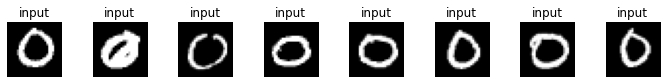

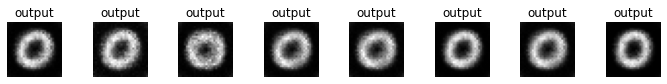

fold:1 epoch:11/50 [tra]loss:1.6565 [val]loss:1.5134 [time]total:1.04sec tra:0.52sec val:0.52sec
fold:1 epoch:12/50 [tra]loss:1.5670 [val]loss:1.4165 [time]total:1.00sec tra:0.51sec val:0.49sec
fold:1 epoch:13/50 [tra]loss:1.4812 [val]loss:1.3307 [time]total:1.04sec tra:0.52sec val:0.52sec
fold:1 epoch:14/50 [tra]loss:1.4385 [val]loss:1.3059 [time]total:1.01sec tra:0.51sec val:0.50sec
fold:1 epoch:15/50 [tra]loss:1.3975 [val]loss:1.2808 [time]total:0.97sec tra:0.48sec val:0.49sec
fold:1 epoch:16/50 [tra]loss:1.3528 [val]loss:1.2101 [time]total:1.05sec tra:0.53sec val:0.51sec
fold:1 epoch:17/50 [tra]loss:1.2815 [val]loss:1.1125 [time]total:0.99sec tra:0.49sec val:0.50sec
fold:1 epoch:18/50 [tra]loss:1.2074 [val]loss:1.0541 [time]total:1.02sec tra:0.52sec val:0.50sec
fold:1 epoch:19/50 [tra]loss:1.1208 [val]loss:0.9488 [time]total:0.99sec tra:0.49sec val:0.49sec
fold:1 epoch:20/50 [tra]loss:1.0398 [val]loss:0.8914 [time]total:0.92sec tra:0.51sec val:0.41sec


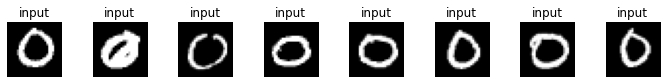

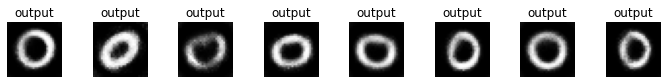

fold:1 epoch:21/50 [tra]loss:0.9756 [val]loss:0.8550 [time]total:1.01sec tra:0.49sec val:0.53sec
fold:1 epoch:22/50 [tra]loss:0.9529 [val]loss:0.8314 [time]total:1.00sec tra:0.51sec val:0.48sec
fold:1 epoch:23/50 [tra]loss:0.9232 [val]loss:0.8105 [time]total:1.00sec tra:0.49sec val:0.51sec
fold:1 epoch:24/50 [tra]loss:0.8975 [val]loss:0.7832 [time]total:1.00sec tra:0.51sec val:0.49sec
fold:1 epoch:25/50 [tra]loss:0.8587 [val]loss:0.7770 [time]total:1.00sec tra:0.48sec val:0.52sec
fold:1 epoch:26/50 [tra]loss:0.8404 [val]loss:0.7484 [time]total:0.95sec tra:0.53sec val:0.42sec
fold:1 epoch:27/50 [tra]loss:0.8323 [val]loss:0.7361 [time]total:1.57sec tra:0.85sec val:0.73sec
fold:1 epoch:28/50 [tra]loss:0.8120 [val]loss:0.7136 [time]total:1.01sec tra:0.52sec val:0.50sec
fold:1 epoch:29/50 [tra]loss:0.8006 [val]loss:0.7046 [time]total:0.96sec tra:0.48sec val:0.47sec
fold:1 epoch:30/50 [tra]loss:0.7949 [val]loss:0.6891 [time]total:1.02sec tra:0.51sec val:0.51sec


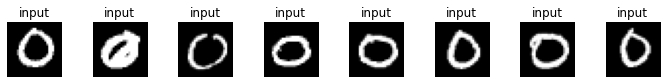

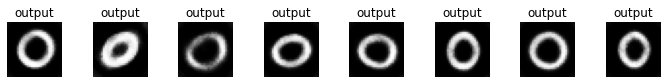

fold:1 epoch:31/50 [tra]loss:0.7756 [val]loss:0.6673 [time]total:1.01sec tra:0.50sec val:0.51sec
fold:1 epoch:32/50 [tra]loss:0.7482 [val]loss:0.6569 [time]total:0.89sec tra:0.49sec val:0.41sec
fold:1 epoch:33/50 [tra]loss:0.7429 [val]loss:0.6475 [time]total:0.98sec tra:0.50sec val:0.48sec
fold:1 epoch:34/50 [tra]loss:0.7230 [val]loss:0.6220 [time]total:0.96sec tra:0.48sec val:0.48sec
fold:1 epoch:35/50 [tra]loss:0.7130 [val]loss:0.6207 [time]total:0.98sec tra:0.50sec val:0.48sec
fold:1 epoch:36/50 [tra]loss:0.6907 [val]loss:0.6028 [time]total:1.01sec tra:0.49sec val:0.52sec
fold:1 epoch:37/50 [tra]loss:0.6773 [val]loss:0.5898 [time]total:0.96sec tra:0.48sec val:0.48sec
fold:1 epoch:38/50 [tra]loss:0.6704 [val]loss:0.5817 [time]total:0.96sec tra:0.48sec val:0.48sec
fold:1 epoch:39/50 [tra]loss:0.6548 [val]loss:0.5676 [time]total:0.97sec tra:0.50sec val:0.48sec
fold:1 epoch:40/50 [tra]loss:0.6492 [val]loss:0.5614 [time]total:1.00sec tra:0.49sec val:0.50sec


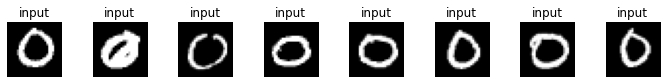

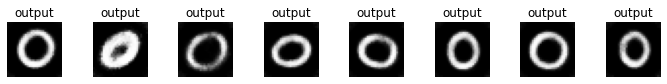

fold:1 epoch:41/50 [tra]loss:0.6443 [val]loss:0.5519 [time]total:1.00sec tra:0.50sec val:0.50sec
fold:1 epoch:42/50 [tra]loss:0.6269 [val]loss:0.5452 [time]total:1.00sec tra:0.48sec val:0.52sec
fold:1 epoch:43/50 [tra]loss:0.6214 [val]loss:0.5416 [time]total:1.01sec tra:0.50sec val:0.51sec
fold:1 epoch:44/50 [tra]loss:0.6182 [val]loss:0.5428 [time]total:1.02sec tra:0.50sec val:0.52sec
fold:1 epoch:45/50 [tra]loss:0.6105 [val]loss:0.5274 [time]total:1.00sec tra:0.49sec val:0.51sec
fold:1 epoch:46/50 [tra]loss:0.6014 [val]loss:0.5242 [time]total:1.02sec tra:0.51sec val:0.51sec
fold:1 epoch:47/50 [tra]loss:0.5862 [val]loss:0.5108 [time]total:1.02sec tra:0.48sec val:0.54sec
fold:1 epoch:48/50 [tra]loss:0.5847 [val]loss:0.5111 [time]total:1.02sec tra:0.50sec val:0.51sec
fold:1 epoch:49/50 [tra]loss:0.5776 [val]loss:0.5084 [time]total:0.98sec tra:0.49sec val:0.49sec
fold:1 epoch:50/50 [tra]loss:0.5806 [val]loss:0.4950 [time]total:1.03sec tra:0.50sec val:0.53sec


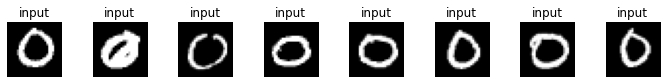

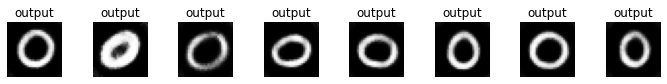

model saved to >> model_epoch50_StratifiedKFold_1_2.pth



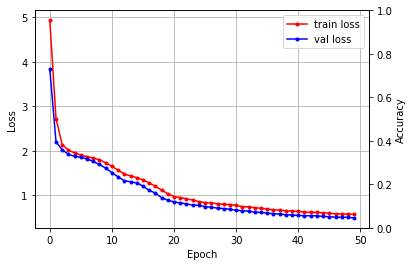

StratifiedKFold fold:2/2
train_N=2962, val_N=2961
fold:2 epoch:1/50 [tra]loss:4.8340 [val]loss:3.5528 [time]total:1.02sec tra:0.50sec val:0.52sec
fold:2 epoch:2/50 [tra]loss:2.6102 [val]loss:2.1410 [time]total:1.02sec tra:0.51sec val:0.51sec
fold:2 epoch:3/50 [tra]loss:2.1122 [val]loss:1.9798 [time]total:0.99sec tra:0.49sec val:0.50sec
fold:2 epoch:4/50 [tra]loss:2.0012 [val]loss:1.9252 [time]total:1.01sec tra:0.51sec val:0.50sec
fold:2 epoch:5/50 [tra]loss:1.9437 [val]loss:1.8693 [time]total:1.00sec tra:0.49sec val:0.50sec
fold:2 epoch:6/50 [tra]loss:1.9082 [val]loss:1.8460 [time]total:0.99sec tra:0.50sec val:0.49sec
fold:2 epoch:7/50 [tra]loss:1.8669 [val]loss:1.8186 [time]total:1.01sec tra:0.49sec val:0.51sec
fold:2 epoch:8/50 [tra]loss:1.8261 [val]loss:1.7755 [time]total:0.93sec tra:0.50sec val:0.42sec
fold:2 epoch:9/50 [tra]loss:1.7715 [val]loss:1.7170 [time]total:1.46sec tra:0.82sec val:0.64sec
fold:2 epoch:10/50 [tra]loss:1.7264 [val]loss:1.6179 [time]total:0.98sec tra:0.50sec v

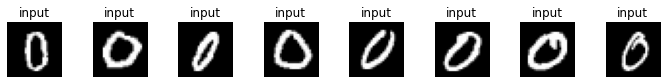

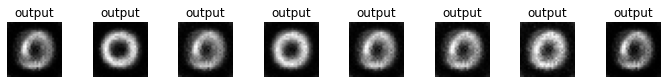

fold:2 epoch:11/50 [tra]loss:1.6576 [val]loss:1.4581 [time]total:1.06sec tra:0.55sec val:0.51sec
fold:2 epoch:12/50 [tra]loss:1.5978 [val]loss:1.3707 [time]total:1.05sec tra:0.52sec val:0.53sec
fold:2 epoch:13/50 [tra]loss:1.5433 [val]loss:1.3187 [time]total:0.94sec tra:0.52sec val:0.42sec
fold:2 epoch:14/50 [tra]loss:1.4878 [val]loss:1.2524 [time]total:0.99sec tra:0.50sec val:0.49sec
fold:2 epoch:15/50 [tra]loss:1.4010 [val]loss:1.1579 [time]total:1.00sec tra:0.52sec val:0.48sec
fold:2 epoch:16/50 [tra]loss:1.3119 [val]loss:1.0802 [time]total:1.05sec tra:0.54sec val:0.52sec
fold:2 epoch:17/50 [tra]loss:1.2434 [val]loss:1.0241 [time]total:0.98sec tra:0.49sec val:0.49sec
fold:2 epoch:18/50 [tra]loss:1.1763 [val]loss:0.9781 [time]total:1.00sec tra:0.49sec val:0.51sec
fold:2 epoch:19/50 [tra]loss:1.1383 [val]loss:0.9507 [time]total:1.00sec tra:0.50sec val:0.50sec
fold:2 epoch:20/50 [tra]loss:1.0731 [val]loss:0.8991 [time]total:1.02sec tra:0.50sec val:0.52sec


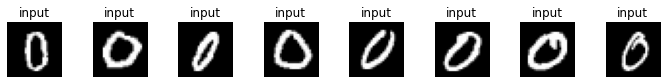

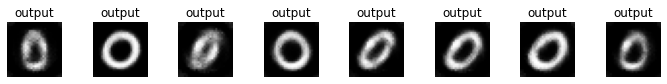

fold:2 epoch:21/50 [tra]loss:1.0170 [val]loss:0.8513 [time]total:1.01sec tra:0.50sec val:0.51sec
fold:2 epoch:22/50 [tra]loss:0.9608 [val]loss:0.8220 [time]total:1.00sec tra:0.51sec val:0.49sec
fold:2 epoch:23/50 [tra]loss:0.9322 [val]loss:0.7921 [time]total:1.00sec tra:0.52sec val:0.48sec
fold:2 epoch:24/50 [tra]loss:0.8912 [val]loss:0.7529 [time]total:0.98sec tra:0.50sec val:0.48sec
fold:2 epoch:25/50 [tra]loss:0.8725 [val]loss:0.7374 [time]total:1.02sec tra:0.50sec val:0.52sec
fold:2 epoch:26/50 [tra]loss:0.8437 [val]loss:0.7065 [time]total:1.04sec tra:0.53sec val:0.52sec
fold:2 epoch:27/50 [tra]loss:0.8133 [val]loss:0.6949 [time]total:1.05sec tra:0.53sec val:0.52sec
fold:2 epoch:28/50 [tra]loss:0.8020 [val]loss:0.6714 [time]total:1.01sec tra:0.51sec val:0.51sec
fold:2 epoch:29/50 [tra]loss:0.7702 [val]loss:0.6561 [time]total:0.98sec tra:0.49sec val:0.49sec
fold:2 epoch:30/50 [tra]loss:0.7517 [val]loss:0.6472 [time]total:1.04sec tra:0.52sec val:0.52sec


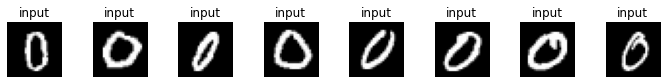

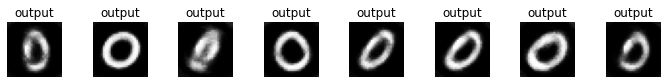

fold:2 epoch:31/50 [tra]loss:0.7380 [val]loss:0.6330 [time]total:1.07sec tra:0.54sec val:0.53sec
fold:2 epoch:32/50 [tra]loss:0.7243 [val]loss:0.6268 [time]total:1.02sec tra:0.52sec val:0.50sec
fold:2 epoch:33/50 [tra]loss:0.7119 [val]loss:0.6097 [time]total:1.01sec tra:0.50sec val:0.52sec
fold:2 epoch:34/50 [tra]loss:0.6946 [val]loss:0.5988 [time]total:0.99sec tra:0.49sec val:0.50sec
fold:2 epoch:35/50 [tra]loss:0.6790 [val]loss:0.5926 [time]total:1.01sec tra:0.49sec val:0.52sec
fold:2 epoch:36/50 [tra]loss:0.6662 [val]loss:0.5800 [time]total:1.04sec tra:0.52sec val:0.52sec
fold:2 epoch:37/50 [tra]loss:0.6581 [val]loss:0.5752 [time]total:0.96sec tra:0.55sec val:0.42sec
fold:2 epoch:38/50 [tra]loss:0.6481 [val]loss:0.5632 [time]total:1.02sec tra:0.53sec val:0.48sec
fold:2 epoch:39/50 [tra]loss:0.6404 [val]loss:0.5580 [time]total:1.01sec tra:0.50sec val:0.51sec
fold:2 epoch:40/50 [tra]loss:0.6175 [val]loss:0.5434 [time]total:1.04sec tra:0.52sec val:0.52sec


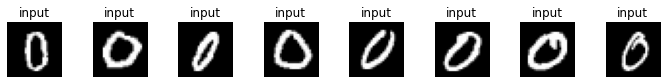

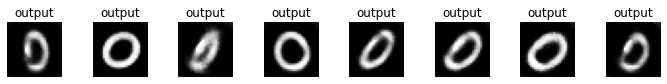

fold:2 epoch:41/50 [tra]loss:0.6094 [val]loss:0.5318 [time]total:1.10sec tra:0.55sec val:0.55sec
fold:2 epoch:42/50 [tra]loss:0.5993 [val]loss:0.5367 [time]total:1.06sec tra:0.52sec val:0.54sec
fold:2 epoch:43/50 [tra]loss:0.5999 [val]loss:0.5175 [time]total:0.96sec tra:0.53sec val:0.42sec
fold:2 epoch:44/50 [tra]loss:0.5908 [val]loss:0.5187 [time]total:0.97sec tra:0.50sec val:0.48sec
fold:2 epoch:45/50 [tra]loss:0.5871 [val]loss:0.5106 [time]total:1.00sec tra:0.52sec val:0.48sec
fold:2 epoch:46/50 [tra]loss:0.5787 [val]loss:0.5120 [time]total:1.01sec tra:0.52sec val:0.48sec
fold:2 epoch:47/50 [tra]loss:0.5696 [val]loss:0.5118 [time]total:0.99sec tra:0.50sec val:0.49sec
fold:2 epoch:48/50 [tra]loss:0.5712 [val]loss:0.5025 [time]total:1.03sec tra:0.52sec val:0.52sec
fold:2 epoch:49/50 [tra]loss:0.5639 [val]loss:0.4960 [time]total:1.04sec tra:0.53sec val:0.51sec
fold:2 epoch:50/50 [tra]loss:0.5663 [val]loss:0.4991 [time]total:1.04sec tra:0.54sec val:0.50sec


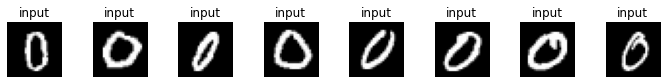

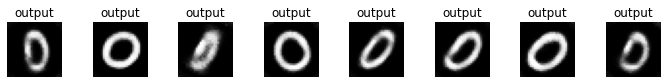

model saved to >> model_epoch50_StratifiedKFold_2_2.pth



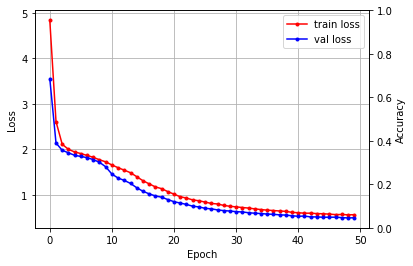

In [9]:
train_models, train_model_paths = train()

# Test

model 1


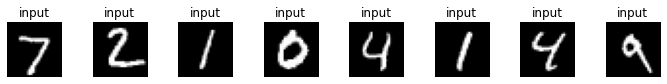

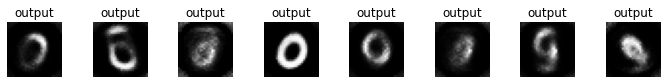

model 2


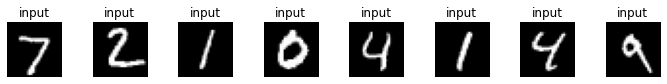

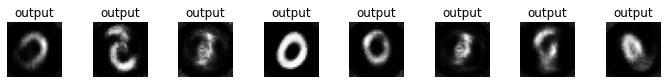

In [12]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data.numpy().astype(np.float32)[..., None]
    test_ys = np.array(test_ds.targets)

    dataset_test = MnistDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            for i, model in enumerate(train_models):
                outputs = model(Xs)

                print(f"model {i + 1}")
                show_sample(Xs, name="input")
                show_sample(outputs, name="output")

            break

test(train_models)

# Anormaly detection

model 1


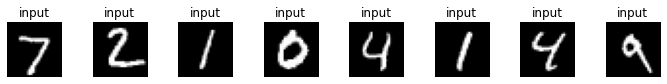

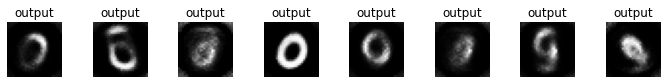

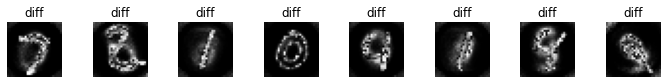

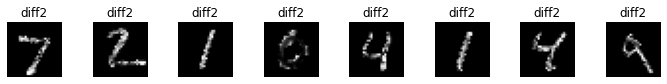

model 2


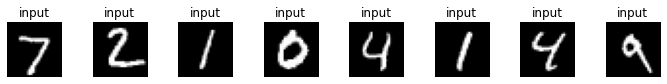

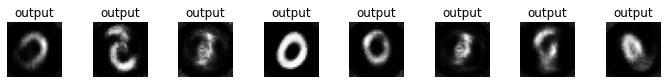

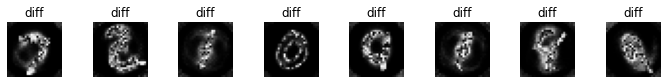

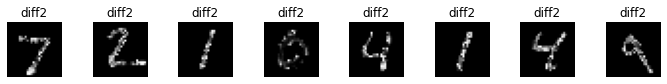

In [13]:
# test
def anormaly_detect(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data.numpy().astype(np.float32)[..., None]
    test_ys = np.array(test_ds.targets)

    dataset_test = MnistDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            for i, model in enumerate(train_models):
                outputs = model(Xs)
                diff_xs = torch.abs(Xs - outputs) * 2 - 1

                diff_xs2 = Xs - outputs
                diff_xs2[diff_xs2 < 0] = 0
                diff_xs2 = diff_xs2 * 2 - 1

                print(f"model {i + 1}")
                show_sample(Xs, name="input")
                show_sample(outputs, name="output")
                show_sample(diff_xs, name="diff")
                show_sample(diff_xs2, name="diff2")

            break

anormaly_detect(train_models)